## 1. Load Data

In [1]:

import numpy as np

# Load npz
data = np.load("../data/cancer_data.npz")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

print(f"Training X shape: {X_train.shape}, y shape: {y_train.shape}")
print(f"Testing X shape: {X_test.shape}, y shape: {y_test.shape}")

Training X shape: (64, 4), y shape: (64,)
Testing X shape: (136, 4), y shape: (136,)


## 2. Traiable Quantum Feature Map

In [2]:
#!/usr/bin/env python3
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))



In [3]:
# update last change
import importlib
import src.feature_map
importlib.reload(src.feature_map)
import numpy as np

from src.feature_map import TrainableQuantumFeatureMap


# Train the feature map
depth = 1
tqfm1 = TrainableQuantumFeatureMap(depth=depth, type_ansatz="TwoLocal", optimizer='COBYLA', maxiter=100)
tqfm1.fit(X_train, y_train)

tqfm2 = TrainableQuantumFeatureMap(depth=depth, type_ansatz="RealAmplitudes", optimizer='COBYLA', maxiter=100)
tqfm2.fit(X_train, y_train)

tqfm3 = TrainableQuantumFeatureMap(depth=depth, type_ansatz="EfficientSU2", optimizer='COBYLA', maxiter=100)
tqfm3.fit(X_train, y_train)


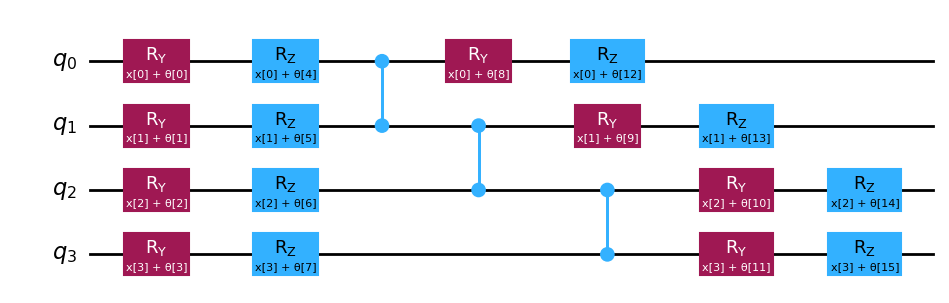

In [4]:
tqfm1.circuit.draw('mpl')

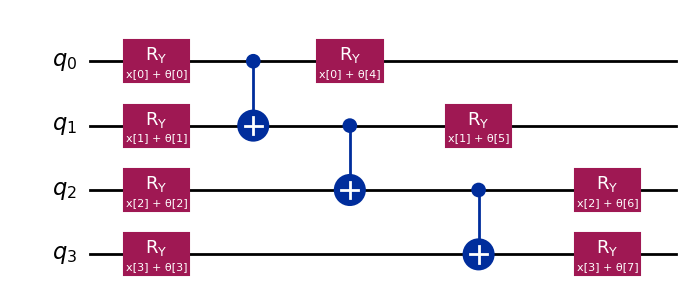

In [5]:
tqfm2.circuit.draw('mpl')

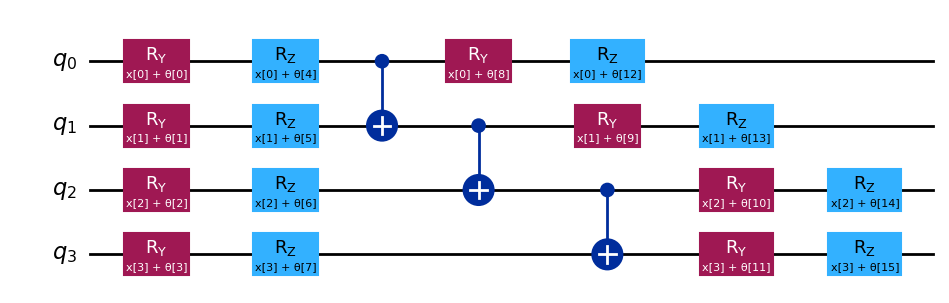

In [6]:
tqfm3.circuit.draw('mpl')

In [7]:
print(f"tqfm1.first_loss: {tqfm1.loss_history[0]}")
print(f"tqfm2.first_loss: {tqfm2.loss_history[0]}")
print(f"tqfm3.first_loss: {tqfm3.loss_history[0]}")

tqfm1.first_loss: 0.5404882426007263
tqfm2.first_loss: 0.6578331291826964
tqfm3.first_loss: 0.6152009013524288


In [8]:
print(f"tqfm1.optimal_value: {tqfm1.optimal_value}")
print(f"tqfm2.optimal_value: {tqfm2.optimal_value}")
print(f"tqfm3.optimal_value: {tqfm3.optimal_value}")

tqfm1.optimal_value: 0.3341283590986681
tqfm2.optimal_value: 0.3258722533962274
tqfm3.optimal_value: 0.21498249836877303


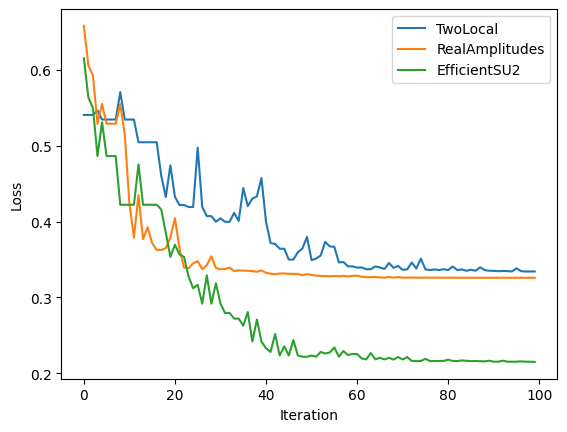

In [9]:
# draw 3 loss curves in one plot
import matplotlib.pyplot as plt
plt.plot(tqfm1.loss_history, label='TwoLocal')
plt.plot(tqfm2.loss_history, label='RealAmplitudes')
plt.plot(tqfm3.loss_history, label='EfficientSU2')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

## 3. Kernel Matrix

In [10]:
# update last change
import importlib
import src.kernel_estimate
importlib.reload(src.kernel_estimate)

from src.kernel_estimate import KernelMatrix

kernel_before1 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm1.init_theta, tqfm1.circuit)
kernel_after1 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm1.optimal_params, tqfm1.circuit)

kernel_before2 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm2.init_theta, tqfm2.circuit)
kernel_after2 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm2.optimal_params, tqfm2.circuit)

kernel_before3 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm3.init_theta, tqfm3.circuit)
kernel_after3 = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm3.optimal_params, tqfm3.circuit)

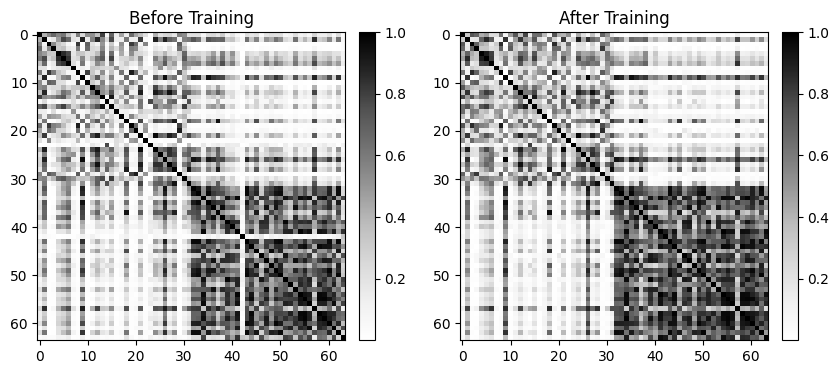

In [11]:
KernelMatrix.plot_multi_kernel_matrices([kernel_before3, kernel_after3],
										titles=['Before Training', 'After Training'],)

## 4. Analysis

This counterintuitive result reveals important insights about quantum feature map training:

In [12]:
# Deep kernel analysis
print("="*60)
print("KERNEL QUALITY ANALYSIS")
print("="*60)


# Class separability analysis
mask = ~np.eye(kernel_before1.shape[0], dtype=bool)
print(f"\nClass Separability Analysis:")
print(f"Training set: {np.sum(y_train == -1)} class -1, {np.sum(y_train == 1)} class 1")

# Compute within-class and between-class similarities
class_0_idx = np.where(y_train == -1)[0]
class_1_idx = np.where(y_train == 1)[0]

# Within-class similarity (should be high)
within_0_before = kernel_before1[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_before = kernel_before1[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()
within_0_after = kernel_after1[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_after = kernel_after1[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()

# Between-class similarity (should be low)
between_before = kernel_before1[np.ix_(class_0_idx, class_1_idx)].mean()
between_after = kernel_after1[np.ix_(class_0_idx, class_1_idx)].mean()

print(f"Within-class similarity:")
print(f"  Class -1: BEFORE={within_0_before:.4f}, AFTER={within_0_after:.4f}")
print(f"  Class +1: BEFORE={within_1_before:.4f}, AFTER={within_1_after:.4f}")
print(f"Between-class similarity:")
print(f"  BEFORE={between_before:.4f}, AFTER={between_after:.4f}")

# 5. Separability ratio
sep_ratio_before = (within_0_before + within_1_before) / (2 * between_before)
sep_ratio_after = (within_0_after + within_1_after) / (2 * between_after)
print(f"\nSeparability ratio (within/between, higher is better):")
print(f"BEFORE: {sep_ratio_before:.4f}")
print(f"AFTER:  {sep_ratio_after:.4f}")
print(f"Change: {((sep_ratio_after - sep_ratio_before)/sep_ratio_before)*100:+.2f}%")

KERNEL QUALITY ANALYSIS

Class Separability Analysis:
Training set: 32 class -1, 32 class 1
Within-class similarity:
  Class -1: BEFORE=0.4074, AFTER=0.3850
  Class +1: BEFORE=0.7955, AFTER=0.5443
Between-class similarity:
  BEFORE=0.4358, AFTER=0.3318

Separability ratio (within/between, higher is better):
BEFORE: 1.3799
AFTER:  1.4004
Change: +1.48%


In [13]:
# Deep kernel analysis
print("="*60)
print("KERNEL QUALITY ANALYSIS")
print("="*60)


# Class separability analysis
mask = ~np.eye(kernel_before2.shape[0], dtype=bool)
print(f"\nClass Separability Analysis:")
print(f"Training set: {np.sum(y_train == -1)} class -1, {np.sum(y_train == 1)} class 1")

# Compute within-class and between-class similarities
class_0_idx = np.where(y_train == -1)[0]
class_1_idx = np.where(y_train == 1)[0]

# Within-class similarity (should be high)
within_0_before = kernel_before2[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_before = kernel_before2[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()
within_0_after = kernel_after2[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_after = kernel_after2[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()

# Between-class similarity (should be low)
between_before = kernel_before2[np.ix_(class_0_idx, class_1_idx)].mean()
between_after = kernel_after2[np.ix_(class_0_idx, class_1_idx)].mean()

print(f"Within-class similarity:")
print(f"  Class -1: BEFORE={within_0_before:.4f}, AFTER={within_0_after:.4f}")
print(f"  Class +1: BEFORE={within_1_before:.4f}, AFTER={within_1_after:.4f}")
print(f"Between-class similarity:")
print(f"  BEFORE={between_before:.4f}, AFTER={between_after:.4f}")

# 5. Separability ratio
sep_ratio_before = (within_0_before + within_1_before) / (2 * between_before)
sep_ratio_after = (within_0_after + within_1_after) / (2 * between_after)
print(f"\nSeparability ratio (within/between, higher is better):")
print(f"BEFORE: {sep_ratio_before:.4f}")
print(f"AFTER:  {sep_ratio_after:.4f}")
print(f"Change: {((sep_ratio_after - sep_ratio_before)/sep_ratio_before)*100:+.2f}%")

KERNEL QUALITY ANALYSIS

Class Separability Analysis:
Training set: 32 class -1, 32 class 1
Within-class similarity:
  Class -1: BEFORE=0.4647, AFTER=0.3875
  Class +1: BEFORE=0.6855, AFTER=0.8177
Between-class similarity:
  BEFORE=0.2794, AFTER=0.3095

Separability ratio (within/between, higher is better):
BEFORE: 2.0583
AFTER:  1.9471
Change: -5.40%


In [14]:
# Deep kernel analysis
print("="*60)
print("KERNEL QUALITY ANALYSIS")
print("="*60)


# Class separability analysis
mask = ~np.eye(kernel_before3.shape[0], dtype=bool)
print(f"\nClass Separability Analysis:")
print(f"Training set: {np.sum(y_train == -1)} class -1, {np.sum(y_train == 1)} class 1")

# Compute within-class and between-class similarities
class_0_idx = np.where(y_train == -1)[0]
class_1_idx = np.where(y_train == 1)[0]

# Within-class similarity (should be high)
within_0_before = kernel_before3[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_before = kernel_before3[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()
within_0_after = kernel_after3[np.ix_(class_0_idx, class_0_idx)][mask[:len(class_0_idx), :len(class_0_idx)]].mean()
within_1_after = kernel_after3[np.ix_(class_1_idx, class_1_idx)][mask[:len(class_1_idx), :len(class_1_idx)]].mean()

# Between-class similarity (should be low)
between_before = kernel_before3[np.ix_(class_0_idx, class_1_idx)].mean()
between_after = kernel_after3[np.ix_(class_0_idx, class_1_idx)].mean()

print(f"Within-class similarity:")
print(f"  Class -1: BEFORE={within_0_before:.4f}, AFTER={within_0_after:.4f}")
print(f"  Class +1: BEFORE={within_1_before:.4f}, AFTER={within_1_after:.4f}")
print(f"Between-class similarity:")
print(f"  BEFORE={between_before:.4f}, AFTER={between_after:.4f}")

# 5. Separability ratio
sep_ratio_before = (within_0_before + within_1_before) / (2 * between_before)
sep_ratio_after = (within_0_after + within_1_after) / (2 * between_after)
print(f"\nSeparability ratio (within/between, higher is better):")
print(f"BEFORE: {sep_ratio_before:.4f}")
print(f"AFTER:  {sep_ratio_after:.4f}")
print(f"Change: {((sep_ratio_after - sep_ratio_before)/sep_ratio_before)*100:+.2f}%")

KERNEL QUALITY ANALYSIS

Class Separability Analysis:
Training set: 32 class -1, 32 class 1
Within-class similarity:
  Class -1: BEFORE=0.3381, AFTER=0.3860
  Class +1: BEFORE=0.6218, AFTER=0.6914
Between-class similarity:
  BEFORE=0.1985, AFTER=0.1747

Separability ratio (within/between, higher is better):
BEFORE: 2.4174
AFTER:  3.0834
Change: +27.55%


In [15]:
# Save the trained quantum feature map circuit
import pickle
with open(f"../data/tqfm_depth{depth}.pkl", "wb") as f:
	pickle.dump(tqfm3, f)

In [16]:
# Save kernel matrix to file
np.save('../data/kernel_matrix_before.npy', kernel_before3)
np.save('../data/kernel_matrix_after.npy', kernel_after3)